In [38]:
import xgboost as xgb
import sklearn
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
pd.options.plotting.backend = 'plotly'

In [39]:
everything = pd.read_parquet('../data/everything_v1.parquet.gzip')

In [40]:
features_list = ['price_diff_lag_1', 'price_diff_lag_2', 'price_diff_lag_3', 'hour', 'day', 'compound']
target_list = ['price_diff']
features_df = everything[features_list]
target_df = everything[target_list]

In [41]:
features_df = features_df.rename(columns={'compound': 'sentiment_score'})

In [58]:
features_df.head(15)

,price_diff_lag_1,price_diff_lag_2,price_diff_lag_3,hour,day,sentiment_score
4,182.76,-424.50,1799.62,15,16,0.063489
5,-390.31,182.76,-424.50,18,16,0.032586
6,1111.34,-390.31,182.76,21,16,0.094229
7,533.01,1111.34,-390.31,0,17,0.117510
8,-1113.80,533.01,1111.34,3,17,0.162449
9,161.91,-1113.80,533.01,6,17,0.076906
10,-165.94,161.91,-1113.80,9,17,0.076150
11,-959.37,-165.94,161.91,12,17,0.070207
12,-268.78,-959.37,-165.94,15,17,0.167008
13,968.33,-268.78,-959.37,18,17,0.093245


In [43]:
X, y = features_df, target_df

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=123
)

In [45]:
params = {
    'min_child_weight': [1, 2, 3],
    'gamma': [0.5, 1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.3, 0.4],
    'max_depth': [2, 3, 4],
    'n_estimators': [50, 100]
}

In [46]:
xgb_regressor = xgb.XGBRegressor(
    learning_rate=0.02,
    objective='reg:squarederror',
    nthread=1,
    eval_metric='mape'
)

In [47]:
grid_search = GridSearchCV(
    xgb_regressor,
    param_grid=params,
    scoring='neg_mean_absolute_percentage_error',
    verbose=1
)

In [48]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
C:\Users\Andrew\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

C:\Users\Andrew\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

C:\Users\Andrew\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

C:\Users\Andrew\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory co

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, eval_metric='mape',
                                    gamma=None, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.02, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimato...
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method

In [49]:
model = grid_search.best_estimator_

In [50]:
preds = model.predict(X_test)

C:\Users\Andrew\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [51]:
preds

array([  94.55737 ,  -20.365992,   21.304955,  108.031044,  135.11246 ,
         26.17528 ,  105.405846,   23.111628,   29.688587,  148.42911 ,
         29.426254,   44.344116,  -46.364082,  133.28441 ,    7.857699,
         29.855606, -148.00195 ,  -50.458576], dtype=float32)

In [52]:
mape = mean_absolute_percentage_error(y_test, preds)

In [53]:
print(mape)

1.180948669793729


In [54]:
results = {
    'Predicted': preds,
    'Actual': y_test['price_diff']
}
results_df = pd.DataFrame.from_dict(results).reset_index(drop=True)

In [68]:
results_df.plot.bar(
    barmode='group',
    labels=dict(index='', value='Bitcoin Price Diff', variable='Variable'),
    title='Bitcoin 3 Hour Price Differences: Predictions vs Actual'
)

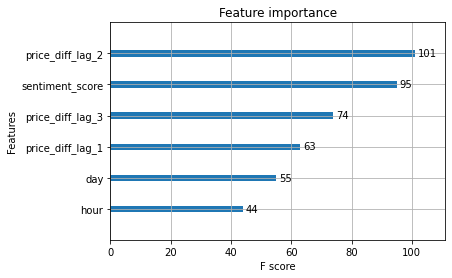

In [56]:
plot_importance(model)